# Идентификация нелинейных объектов управления
Цель работы: изучение инструментальных средств идентификации  объектов управления.

Задачи: 
- построение линейной компьютерной модели, идентификация модели методом подстраиваемых параметров; 
- построение компьютерной модели объекта управления с учетом нелинейности объекта, идентификация модели методом подстраиваемых параметров; 
- построение нейросетевой модели объекта управления.

Первоочередной задачей при разработке системы управления является получение модели объекта управления. Существует два способа построения модели объекта: аналитический и экспериментальный. В случае аналитического способа имеются априорные знания о законах природы, которым подчиняются процессы, что позволяет описать объект без проведения экспериментов. В случае «серого» ящика о внутренней структуре объекта известна некоторая информация, но ее недостаточно для построения модели. Тогда применяют экспериментальный способ, который заключается в подаче тестовых сигналов на вход объекта, анализе реакций и обработке данных. На практике комбинируют аналитический и экспериментальный способы. 

Способы идентификации далее рассмотрены без объяснения методов и алгоритмов обработки данных, которые детально изучаются в рамках дисциплины «Идентификация объектов управления». Существенным упрощением работы является отсутствие случайных возмущений. Это исключает необходимость в многократных экспериментах, хотя не вполне соответствует понятию и термину «идентификация». 

Рассматриваются компьютерные имитаторы объектов с одним входом и одним выходом (типа SISO). 

## Компьютерная имитация объекта 

Для выполнения лабораторной работы необходимо подставить номер своего варианта в переменную variant

In [0]:
variant = 5

Далее описывается объект, который в рамках работы необъодимо идентифицировать.
Объект описывается классом, для получения функции системы ДУ необходимо вызвать фунцию getODE(), использовать полученную функцию стоит только для оценки параметров "идеальной" модели.
$$
d\bar{x} = F(\bar{x})
$$

In [0]:
from scipy.integrate import odeint
import numpy as np

class real_object:
    def __init__(self, variant):
        self._var = variant
        self._ctrl_fcn = real_object._default_control
        self.lin_par_1 = variant % 10 * 0.2
        self.lin_par_2 = ((32-variant) % 9 +0.1 ) * 2.5
        self.nonlin_par_1 = variant % 15 * 0.35
        self.nonlin_par_2 = variant % 12 * 0.45
        self.nonlin_fcns = [self.deadZone, self.saturation, self.relay]
        self.nonlin_names = ['deadZone', 'saturation', 'relay']
        self.nonlin_type = variant % 3
        self._params = [self.lin_par_1, self.lin_par_2, self.nonlin_par_1, self.nonlin_par_2]
        print(self.lin_par_1, self.lin_par_2, self.nonlin_par_1, self.nonlin_par_2)
        
    def deadZone(self, x, p1, p2):
        if np.abs(x) < p1:
            x = 0
        elif x > 0:
            x = x - p1
        elif x < 0:
            x = x + p2    
        return x
    
    def saturation(self, x, p1, p2):
        if x > p1:
            x = p1
        elif x < -p2:
            x = -p2
        return x
    
    def relay(self, x, p1, p2):
        if x > 0:
            return p1
        else:
            return -p2
                
    def _ode(self, x, t, k):
        '''
        Функция принимает на вход вектор переменных состояния и реализует по сути систему в форме Коши
        x -- текущий вектор переменных состояния
        t -- текущее время
        k -- значения параметров
        '''
        y = x
        u = self._get_u(x, t)
        lin_par_1, lin_par_2, nonlin_par_1, nonlin_par_2 = k
        
        dydt = (lin_par_1 * self.nonlin_fcns[self.nonlin_type](u, nonlin_par_1, nonlin_par_2) - x) / lin_par_2
        return dydt
    
    def _default_control(x, t):
        """
        Управление по умолчанию. Нулевой вход
        """
        return 0
    
    def _get_u(self, x, t):
        """
        Получить значение управления при значениях переменных состояния x и времени t
        """
        return self._ctrl_fcn(x, t)
    
    def set_u_fcn(self, new_u):
        """
        Установить новую функцию управления
        формат функции: fcn(x, t)
        """
        self._ctrl_fcn = new_u
    
    def calcODE(self, y0, ts=10, nt=1001):
        """
        Вспомогательная функция для получения решения систему ДУ, "Проведение эксперимента" с заданным воздействием
        """
        y0 = [y0,]
        t = np.linspace(0, ts, nt)
        args = (self._params, )
        sol = odeint(self._ode, y0, t, args)
        return sol, t
    
    def getODE(self):        
        """
        Получить "идеальную" модель объекта без параметров
        """
        return self._ode
    
    def get_nonlinear_element_type(self):
        return self.nonlin_names[self.nonlin_type]

### Свободные движения объекта

В качестве примера и проверки работы модели построим свободные движения системы. 
Свободные движения -- это движения с нулевым входом.

1.0 0.25 1.75 2.25


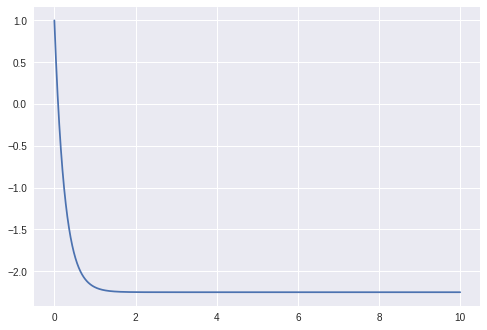

In [3]:
import matplotlib.pyplot as plt

obj = real_object(variant)
y0 = 1
sol, t = obj.calcODE(y0)
plt.plot(t, sol)

## Проведение экспериментов

Первым шагом анализа объекта является проведение экспериментов. Одним из основных методов проведения экспериментов является подача на вход объекта тестового сигнала. Минусом такого подхода является потенциальная возможность выхода из строя исследуемого объекта, так что в инженерной практике стоит применять такой подход с осторожностью.

В рамках лабораторной работы будет исследоваться отклик объекта на импульсное, ступенчатое, гармоническое и случайное воздействие. В качестве тестовых воздействий использовать:
- импульсное воздействие длинной 0,01 с и амплитудой 100 (приблилительная аппроксимация дельта-функции);
- единичное ступенчатое воздействие;
- меандр;
- случайное воздействие типа "белый шум" или "окрашенный шум".

В качестве примера анализа системы будет рассмотрена реакция системы на моногармонический сигнал.

### Моногармонический сигнал

Первым шагом в проведение эксперимента является получение сигнала. Положим, что к качестве тестового сигнала будем использовать моногармонический сигнал амплитудой 0.5 и частотой 1 герц.

Так как для задачи моделирования объекта необходимо передавать функцию, а не конкретную реализацию, реализуем функцию, возвращающую моногармонический сигнал и проведем эксперимент:

1.0 0.25 1.75 2.25


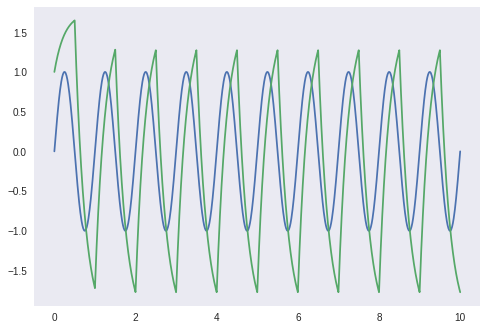

In [4]:
def monoharm_u(x, t):
    return 1*np.sin(t * 2 * np.pi)

#Создаем экземпляр класса объекта
obj = real_object(variant)

#Задаем функцию управления (в нашем случает тестовый моногармонический сигнал)
obj.set_u_fcn(monoharm_u)

# Задаем начальные условия
y0 = 1

# Проводим эксперимент
sol, t = obj.calcODE(y0)
# И строим управляющее воздействие. В случае, если функция управления -- скалярная, то ее стоит векторизовать.
u = monoharm_u(0, t)

# Строим графики входа и выходов системы 
plt.plot(t, u)
plt.plot(t, sol)
plt.grid()

## Создание модели и оценка ее параметров

Оценка параметров в общем случае не является тривиальной задачей. Расмотрим оценку параметров с помощью метода наименьших квадратов.

Для упрощения процесса оценки параметров  реализуем соответствующий класс.

In [0]:
from scipy import optimize
from scipy import integrate, interpolate

class parameter_estimator():
    def __init__(self, experiments, f):
        """
        experiments -- список кортежей с данными экспериментов в формате [x_data, y_data] (вход, выход)
        f -- функция, реализующая дифференциальное уравнение модели
        """
        self._experiments = experiments
        self._f = f
        # Предполагаем, что все переменные состояния наблюдаемые, однако в общем случае это не так
        x_data, y_data = experiments[0]
        self.n_observed = 1 # y_data.shape[1]

    def my_ls_func(self, x, teta):
        """
        Определение функции, возвращающей значения решения ДУ в
        процессе оценки параметров
        x заданные (временные) точки, где известно решение
        (экспериментальные данные)
        teta -- массив с текущим значением оцениваемых параметров.
        Первые self._y0_len элементов -- начальные условия,
        остальные -- параметры ДУ
        """
        # Для передачи функуии используем ламбда-выражение с подставленными
        # параметрами
        # Вычислим значения дифференциального уравления в точках "x"
        r = integrate.odeint(lambda y, t: self._f(y, t, teta[self._y0_len:]),
                             teta[0:self._y0_len], x)
        # Возвращаем только наблюдаемые переменные
        return r[:, 0:self.n_observed]
    
    def estimate_ode(self, y0, guess):
        """
        Произвести оценку параметров дифференциального уравнения с заданными
        начальными значениями параметров:
            y0 -- начальные условия ДУ
            guess -- параметры ДУ
        """
        # Сохраняем число начальных условий
        self._y0_len = len(y0)
        # Создаем вектор оцениваемых параметров,
        # включающий в себя начальные условия
        est_values = np.concatenate((y0, guess))
        c = self.estimate_param(est_values)
        # В возвращаемом значении разделяем начальные условия и параметры
        return c[self._y0_len:], c[0:self._y0_len]

    def f_resid(self, p):
        """
        Функция для передачи в optimize.leastsq
        При дальнейших вычислениях значения, возвращаемые этой функцией,
        будут возведены в квадрат и просуммированы.
                
        """
        delta = []
        # Получаем ошибку для всех экспериментов при заданных параметрах модели
        for data in self._experiments:
            x_data, y_data = data
            d = y_data - self.my_ls_func(x_data, p)
            d = d.flatten() 
            delta.append(d)
        delta = np.array(delta)
        
        return delta.flatten()  # Преобразуем в одномерный массив
    
    def calcODE(self, args, y0, x0=0, xEnd=10, nt=1001):
        """
        Служебная функция для решения ДУ
        """
        t = np.linspace(x0, xEnd, nt)
        sol = odeint(self._f, y0, t, args)
        return sol, t
    
    def estimate_param(self, guess):
        """
        Произвести оценку параметров ДУ
            guess -- параметры ДУ
        """
        self._est_values = guess
        # Решить оптимизационную задачу - решение в переменной c
        res = optimize.least_squares(self.f_resid, self._est_values)
        return res.x

### Идеальная модель

Для проверки работоспособности инструмента оценки параметров произведем оценку параметров "идеальной модели"

Estimated parameter: [1.07627337 0.26429036 1.72311029 2.19191599]
Estimated initial condition: [0.99804167]


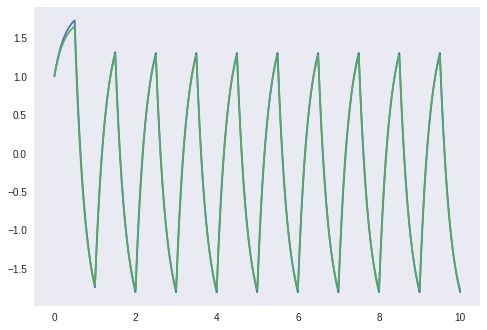

In [6]:
guess = [1.1, 0.25, 1.75, 2.2]  # Начальные значения для параматров системы
y0 = [1, ]  # Стартовые начальные значения для системы ДУ

estimator = parameter_estimator([[t, sol],], obj.getODE())
est_par = estimator.estimate_ode(y0, guess)
print("Estimated parameter: {}".format(est_par[0]))
print("Estimated initial condition: {}".format(est_par[1]))

#1.0 0.25 1.75 2.25
# Строим графики входа и выходов системы 
y0 = est_par[1]
args = (est_par[0],)
sol_ideal = odeint(obj.getODE(), y0, t, args)

plt.plot(t, sol_ideal)
plt.plot(t, sol)
plt.grid()

### Линейная модель

После рализации механизма оценки параметров можно провести оценку параметров линейной модели.

Принять гипотезу о классе модели объекта и о предполагаемом порядке можно по виду отклика на ступенчатое воздействие.

Проведите оценку параметров с учетом всех проведенных экспериментов (необходимо добавить все эксперименты). 

Estimated parameter: [2.46867649 0.23859801]
Estimated initial condition: [1.15788466]


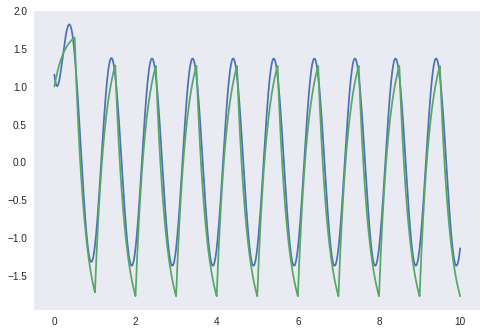

In [8]:
def ode_lin(x, t, k):
    """
    Функция, рализующая систему ДУ маятника с трением
    """
    y = x
    K = k[0]
    T = k[1]
    u = monoharm_u(0, t)
    dydt = (K*u-y)/T
    return dydt

guess = [0.2, 0.3]  # Начальные значения для параматров системы
y0 = [0,]  # Стартовые начальные значения для системы ДУ

estimator = parameter_estimator([[t, sol],], ode_lin)
est_par = estimator.estimate_ode(y0, guess)
print("Estimated parameter: {}".format(est_par[0]))
print("Estimated initial condition: {}".format(est_par[1]))

y0 = est_par[1]
args = (est_par[0],)
sol_lin = odeint(ode_lin, y0, t, args)

plt.plot(t, sol_lin)
plt.plot(t, sol)
plt.grid()

### Нелинейная модель

Как видно из предыдущего эксперимента, параметры линейной модели не соответстует реальным параметрам системы. Поэтому предположим, что в системе имеется нелинейность.

Обратите внимание, что в разных вариантах тип нелинейности может отличаться, а предположить тип можно по виду отклика системы на тестовые воздействия.

Модель и код для нелинейной модели предлагается написаться самостоятельно.

### Нейросетевая модель

Если точный вид нелинейности является неизвестным и нетиповым, то  можно воспользоваться универсальной моделью на базе искусственных нейронных сетей. Процедура идентификации, т. е. подстройка параметров сети мало отличается от заданной исследователем типовой модели, однако, как правило, используются более сложные методы оптимизации в силу большего числа параметров.

В данной лабораторной работе предлагается воспользоваться библиотекой машинного обучения Keras, которая имеет достаточно простой интерфейс, но содержит большинство современных инструментов в этой области.

Строго говоря, произведенные в рамках работы 4 эксперимента, как правило, будут недостаточными для полноценного обучения нейросетевой модели с достаточной степенью обобщения, однако, выполняя эту часть работы вы получите основные навыки работы с нейронными сетями.

Изначально идея нейросетевых моделей пришла из биологии на основе биологического нейрона, однако искусственные нейронные сети имеют общего с биологическими только название. Если опустить вопросы связанные с обучением и специфическими арзитектурами, то нейронные сети можно предстваить, как различного рода соединения исскуственных нейронов, являющиеся взвешенным сумматором и описываемых следующищи формулами:
$$
y = f(u) \\
u = \sum_{i=1}^{n}  \omega_i x_i + \omega_0 x_0
$$

Где $x_i$ - сигнал на входе нейрона, $\omega_i$ - вес соответствующего входа, $\omega_0, x_0$ дополнительный инициализирующий вход и его вес, обеспечивающий постоянное смещение. $f(u)$ - функция активации, которой может являться одна из множества линейных или нелинейных функций.

Для аппроксимации динамических систем необходимо (предпочтительно) использовать рекуррентные нейронные сети, но в любом случае, для работы с временными рядами необходимо преобразовать датасет в подходящий формат.

Рекуррентные нейронные сети отличаются от сетей прямого распространения тем, что имеют внетренние обратные связи, т.е. зависимость входа от выхода, что делает их похожии на БИХ фильтры. Для обучения таких нейронных сетей обычно принимается, что модель имеет порядок $N$ и таким образом значимое количество прошлых отсчетов равно $N$, тогда вход рекуррентной сети имеет форму последовательности длинной $N+1$, при этом количество входов может отличаться от 1.

#### Подготовка датасета

Исходя из вышесказанноего, необходимо преобразовать экспериментальные данные в отрезки по $N+1$ отчетов.

In [0]:
def series2dataset(data, seq_len):
    """
    Преобразование временной последовательнсти к формату датасета
    Шаг дискретизации должен быть постоянным
    """
    dataset = []
    for i in range(data.shape[0]-seq_len):
        r = np.copy(data[i:i+seq_len])
        dataset.append(r)
    return np.array(dataset)
    

Теперь надо преобразовать полученные ранее в экспериментах данные в датасет для обучения нейронной сети. 

Однако, предварительно данные необходимо нормализовать. Как правило данные нормируются в диапазонах $[0, 1]$ или $[-1, 1]$, в нашем случае примем второй вариант.

Стоит отметить, что стратегия выбора тестовой выборки может быть разной, например, выбор 0.3 части от каждго эксперимента в качестве тестового или выбор одного эксперимента целиков в качестве тестового, однако эти данные не должны быть перемещаны.
В рамках выполнения работы вам необходимо модифицировать следующий код, чтобы сформировать датасет из всех экспериментов, а нормализация должна происходить по датасету с максимальными значениями.

In [10]:
from sklearn.preprocessing import MinMaxScaler
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))

values = monoharm_u(0, t)
model_order = 5
x_values = series2dataset(values, model_order)
x_values = np.expand_dims(x_values,2)
print(x_values.shape)

# Разделим на тестовую и обучающие выборки
n_train_samples = int(x_values.shape[0] * 0.7)

train_X = x_values[:n_train_samples, :]
test_X = x_values[n_train_samples:, :]

y_values = scaler.fit_transform(sol)
y_values = y_values[model_order:]
train_y = y_values[:n_train_samples]
test_y = y_values[n_train_samples:]

print("Shape of train is {}, {}, shape of test is {}, {}".format(train_X.shape, 
                                                                 train_y.shape, 
                                                                 test_X.shape, 
                                                                 test_y.shape))


(996, 5, 1)
Shape of train is (697, 5, 1), (697, 1), shape of test is (299, 5, 1), (299, 1)


#### Модель нейронной сети

Keras поддерживает две разных идеалогии построения нейросетевой модели: последовательная и функциональная. Первая является боле простой, ее и будем использовать. Подробности можно почитать [тут](https://keras.io/getting-started/sequential-model-guide/).

В качестве примера предложено построение примитивной по размерам и архитектуре [LSTM](https://digiratory.ru/575) сети. Для улучшения качества можно варьировать размерность модели (в процессе формаирования датасета) и размер нейронной сети.

In [11]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


Следующим очевидным шагом является обучение моделии и построение графика результатов обучения.

Для улучшения обучения можно варьировать длительность обучения и размер batch. 


Instructions for updating:
Use tf.cast instead.
Train on 697 samples, validate on 299 samples
Epoch 1/50
697/697 [==============================] - 1s 2ms/step - loss: 0.3366 - val_loss: 0.2542
Epoch 2/50
697/697 [==============================] - 0s 119us/step - loss: 0.2518 - val_loss: 0.1964
Epoch 3/50
697/697 [==============================] - 0s 109us/step - loss: 0.2029 - val_loss: 0.1743
Epoch 4/50
697/697 [==============================] - 0s 108us/step - loss: 0.1892 - val_loss: 0.1771
Epoch 5/50
697/697 [==============================] - 0s 112us/step - loss: 0.1894 - val_loss: 0.1758
Epoch 6/50
697/697 [==============================] - 0s 110us/step - loss: 0.1867 - val_loss: 0.1721
Epoch 7/50
697/697 [==============================] - 0s 99us/step - loss: 0.1854 - val_loss: 0.1705
Epoch 8/50
697/697 [==============================] - 0s 122us/step - loss: 0.1847 - val_loss: 0.1695
Epoch 9/50
697/697 [==============================] - 0s 96us/step - loss: 0.1836 - val_loss:

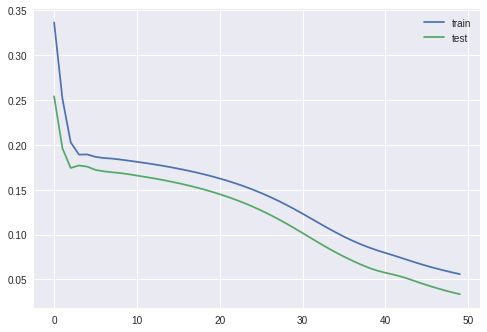

In [12]:
# fit network
history = model.fit(train_X, 
                    train_y, 
                    epochs=50, 
                    batch_size=72, 
                    validation_data=(test_X, test_y), 
                    verbose=1, 
                    shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


Последним шагом будет построение предсказания для тестовой выборки и расчета его среднеквадратичного отклонения. При работе с несколькими экспериментами, необходимо будет модифицировать код.

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt

#делаем предсказание
yhat = model.predict(test_X)

# обратное масштабирование для прогноза
inv_yhat = yhat #scaler.inverse_transform(yhat)
#inv_yhat = inv_yhat[:,0]
# обратное масштабирование для фактического
inv_y = test_y #scaler.inverse_transform(test_y)
#inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.183


Последним шагом является визуализация работы нейронной сети. Покажем работу сети, аналогично предыдушему пункту. Обратное масштабирование делать не обязательно, т.к. цель показать корректность работы только графически.

(996, 5, 1) (996, 1)


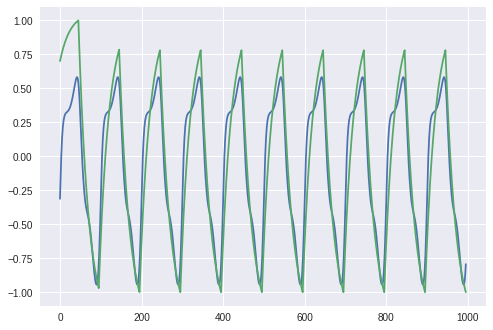

In [14]:

# Соединяем обратно входные данные
X = np.concatenate((train_X, test_X), axis=0)
Y_real = np.concatenate((train_y, test_y), axis=0)
#делаем предсказание
Y = model.predict(X)

print(X.shape, Y.shape)

plt.plot(Y)
plt.plot(Y_real)